# General workflow
This workflow is a starting point to demonstrate the functionality of the containers and to detect and classify difficult cases

In [1]:

import numpy as np
import pandas as pd
import skimage
import Images
import ModelUNet_rep


C:\Users\BKY\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#some definitions
debug=False #perform on a subset --> faster
model_shape=(256,256,3) #works with shape (2^x, 2^x) only?
model_name='unet_v1_{}x{}'.format(model_shape[0],model_shape[1])
if debug:
    model_name += '_debug'

print('the model will be called \''+model_name+'\'')


the model will be called 'unet_v1_256x256'


## Training
* load training data
* train the model (if not yet done)
* 

In [3]:
train=Images.Images("../input/stage1_train")
if debug:
    #subselect, to make it faster 
    train=train.subset(idx=range(20))
    #todo: overload [] to get this


#set aside 10% for validation
val=train.subset(np.arange(train.n()*.9, train.n()))
train=train.subset(np.arange(train.n()*.9,))

#load the image files (in original size)    
train.load_images()
train.load_masks()
train.features.head()    



100%|████████████████████████████████████████████████████████████████████████████████| 603/603 [01:14<00:00,  8.13it/s]


,ids,size_x,size_y,n_channels,nuclei_n,nuclei_meanSz,nuclei_stdSz,nuclei_minSz,nuclei_maxSz
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,256,256,1,27,211,132,21,460
1,003cee89357d9fe13516167fd67b609a164651b2193458...,256,256,1,36,131,37,35,276
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,256,320,3,70,419,208,56,1067
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,256,320,3,86,168,151,22,752
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,256,320,3,7,813,402,152,1563


In [4]:
# initialize and train the model 
# to detect unlabled masks (e.g. the forground vs background)


m_file=model_name+'.h5'

model=ModelUNet_rep.ModelUNet(m_file=m_file, shape=(256,256,3))
#question: should the model design be adapted according to image dimensions?
if not model.trained:
    model.fit_model(train)


found model file


making predictions...
rescale probability vector...
skimage version: 0.13.1
labeling predinctions...
   size_x  size_y  n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  \
0     256     256           1        27            211           132   
1     256     256           1        36            131            37   
2     256     320           3        70            419           208   
3     256     320           3        86            168           151   
4     256     320           3         7            813           402   

   nuclei_minSz  nuclei_maxSz  iou_score  iou_th50  iou_th95  
0            21           460   0.440741  0.592593  0.000000  
1            35           276   0.597222  0.916667  0.027778  
2            56          1067   0.000000  0.000000  0.000000  
3            22           752   0.000000  0.000000  0.000000  
4           152          1563   0.000000  0.000000  0.000000  
expected LB score(train): 0.374781327180684
                                            

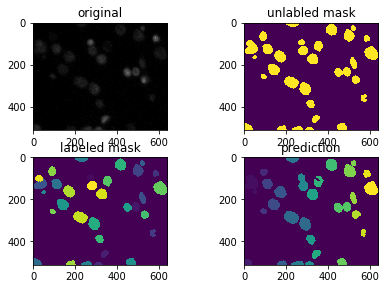

In [5]:

#unlabled prediction (probability of pixle belonging to forground) 
#scaled to the dimensions of the model (e.g. 256x256)
print('making predictions...')
scaled_pred=model.predict_unlabeld(train)


print('rescale probability vector...')
# rescaling performs anti-aliasing, which can disturb lable masks
# it cannot be swhiched of for my version of skimage 0.13.1, only with dev0.14
print("skimage version: {}".format(skimage.__version__))
# for the probability vector antialiasing should be rather beneficial
unlab_pred=train.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5) #this function should also use the images
#add labled predictions to container
train.add_pred(pred)
# this adds iou scores to train.features
print( train.features.drop(['ids'], axis=1).head() ) 
print("expected LB score(train): {}".format(np.mean(train.features['iou_score'])))

train.show_image()

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.45it/s]


making predictions...
rescale probability vector...
labeling predinctions...
expected LB score(val): 0.42449918025630035
                                                  ids  size_x  size_y  \
41  f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d...     360     360   

    n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
41           1        17           2291          1141           194   

    nuclei_maxSz  iou_score  iou_th50  iou_th95  
41          4335   0.629412  0.764706  0.058824  


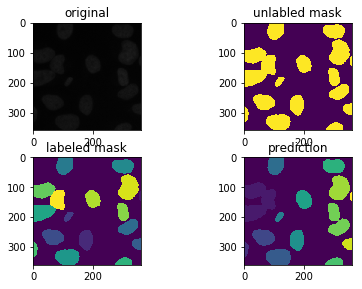

In [6]:
#same on validation data
val.load_images()
val.load_masks()
print('making predictions...')
scaled_pred=model.predict_unlabeld(val)
print('rescale probability vector...')
unlab_pred=val.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')
print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5) 
val.add_pred(pred)
val.features.drop(['ids'], axis=1).head()
print("expected LB score(val): {}".format(np.mean(val.features['iou_score'])))
val.show_image()

## Prediction (on test data)
* load test data
* use model to predict masks
* prepare submission file

In [7]:
test=Images.Images("../input/stage1_test")

#load the image files (in original size)    
test.load_images()

test.features.head()    


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 43.75it/s]


,ids,size_x,size_y,n_channels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,256,256,1
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,519,253,1
2,0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed3...,256,256,1
3,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,256,256,1
4,0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa...,256,256,1


In [8]:
print('making predictions...')
scaled_pred=model.predict_unlabeld(test)


print('rescale probability vector...')
unlab_pred=test.rescale(scaled_pred, scale=None, dtype=np.float32, mode='reflect')

print('labeling predinctions...')
pred=model.label(unlab_pred, th=0.5)
test.add_pred(pred)


making predictions...
rescale probability vector...
labeling predinctions...


In [9]:
submission_file='submission' + model_name + '.csv'
test.write_submission(submission_file)



0

Scores for first test image:
unlabeled IoU: [0.]
unlabeled IoU per nucleus: [0.75221239 0.81034483 0.83793103 0.77428571 0.78235294 0.73662551]
mean IoU: 0.7822920702191624
fraction of nuclei has IoU > 0.5: 1.0
fraction of nuclei has IoU > 0.95: 0.0
IoU score (over range of thresholds): 0.6166666666666667
                                                 ids  size_x  size_y  \
0  e5f8ad0f0a43af8ca57e31e16800108abdfb44a7e962a7...     256     256   

   n_channels  nuclei_n  nuclei_meanSz  nuclei_stdSz  nuclei_minSz  \
0           1         6            198            72            85   

   nuclei_maxSz  iou_score  iou_th50  iou_th95  
0           282   0.616667       1.0       0.0  


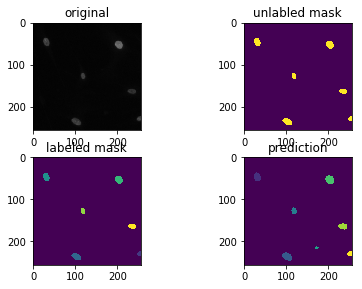

In [10]:

##########
# scores #
##########
print('Scores for first test image:')
#unlabeled IOU
print('unlabeled IoU: {}'.format(Images.iou(val.masks[0] > 0, unlab_pred[0]>0.5)))
#labled IOUs per nucleus
print('unlabeled IoU per nucleus: {}'.format(Images.iou(val.masks[0], val.pred[0])))
#mean IOU
print('mean IoU: {}'.format(np.mean(Images.iou(val.masks[0], val.pred[0]))))
# fraction of nuclei > th
print('fraction of nuclei has IoU > 0.5: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.5])))
print('fraction of nuclei has IoU > 0.95: {}'.format(Images.iou_score(val.masks[0], val.pred[0], th=[.95])))
# fraction of nuclei > th average over range of thresholds
print('IoU score (over range of thresholds): {}'.format(Images.iou_score(val.masks[0], val.pred[0])))

val.show_image(0)